# Evaluating Gaussian Processes on collected data

In [77]:
import os
import time

from collections import defaultdict
from tempfile import NamedTemporaryFile
from typing import List, Tuple

import requests
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error

from optpresso import __file__ as optpresso_path
from optpresso.utils import GroundsLoader
from optpresso.data.config import load_config
from optpresso.data.partition import find_test_paths
from optpresso.models.serialization import load_model

from IPython.core.display import display

In [78]:
# Disable GPU, fast enough without
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv"


In [96]:
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
for char in [' ', '(', ')', "%", "/", "\\", '"']:
    df.columns = df.columns.str.strip().str.lower().str.replace(char, '')
df = df[df["grinder"].astype(bool)][df["grindersetting"].astype(bool)]
# Only look at data with TDS values and ratings
invalid_indices = df[df["time"].isna()].index
df.drop(invalid_indices, inplace=True)
df = df[(df["grinder"] == "MC3")]
# df.drop(invalid_indices, inplace=True)
df["roastdate"] = df["roastdate"].astype(str).replace("nan", "")
# df = df.assign(extraction_yield = df.tdsatagounfiltered * df.output / df.coffeegrams)

In [97]:
# Do an 80:20 cross validation split
train = df.sample(frac=0.8)
test = df.drop(train.index)
print(len(test), len(train))
# train = df[msk]
# test = df[~msk]

157 628


In [98]:
train

,coffeegrams,time,timeprediction,tdsatagounfiltered,output,grinder,grindersetting,coffee,roastdate,arbitraryrating1-10,details,brewratio,machine,date
999,18.0,41.0,NaN,NaN,37.4,MC3,9,Square Mile Coffee Roasters - Sweetshop,,7.0,spro,2.077778,Linea Mini,2021-04-29T14:04:23Z
1091,18.0,30.0,NaN,NaN,38.8,MC3,8.25,Facsimile - Yandaro Burundi,05/02/21,7.0,spro,2.155556,Linea Mini,2021-05-21T13:45:19Z
868,18.0,35.0,NaN,NaN,36.0,MC3,8.25,Luna - Marshmallow Magic,,8.0,spro - no images - no ocd,2.000000,Linea Mini,2021-04-02T14:49:13Z
101,18.0,31.0,NaN,NaN,36.0,MC3,8.25,Madcap - Yenni Reinoso,,7.0,spro,2.000000,Linea Mini,NaN
286,18.0,5.0,NaN,NaN,36.0,MC3,14,Amazon Basic - Columbian Medium,,0.0,waste,2.000000,Linea Mini,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,18.0,29.0,NaN,NaN,36.0,MC3,8.25,Madcap - Third Coast,,5.0,spro,2.000000,Linea Mini,2021-03-09T15:26:34Z
920,18.0,35.0,NaN,9.43,39.0,MC3,7.75,Slow Burn - Kenya Kaliluni AA,,6.0,spro,2.166667,Linea Mini,NaN
437,18.0,35.0,NaN,NaN,36.0,MC3,8.75,Candlestick - Columbia,,0.0,waste - no images,2.000000,Linea Mini,NaN
684,18.0,22.0,NaN,NaN,36.0,MC3,7,Little Bear - Costa Rica,,0.0,waste - no images,2.000000,Linea Mini,2021-02-25T14:24:17Z


## Evaluate using Gaussian Process to make predictions

It is feasible to build a personalized Gaussian Process (GP) model, and this is to do a basic proof of concept to see if it isn't totally worthless.

With Dropped columns: None
[9.64146985 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985
 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985
 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985
 9.64146985 9.64146985 9.64146985 9.64146985 9.69107865 9.64146985
 9.64146985 9.67875281 9.64146985 9.64146985 9.64146985 9.64146985
 9.64146985 9.67875281 9.67875281 9.64146985 9.64146985 9.64146985
 9.6692816  9.64146985 9.64146985 9.64146985 9.64146985 9.67875281
 9.67875281 9.67875281 9.67875281 9.67875281 9.67875281 9.67875281
 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985
 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985
 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985
 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985
 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985
 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985 9.64146985
 9.64146985 9.64146985 9.64146985 9

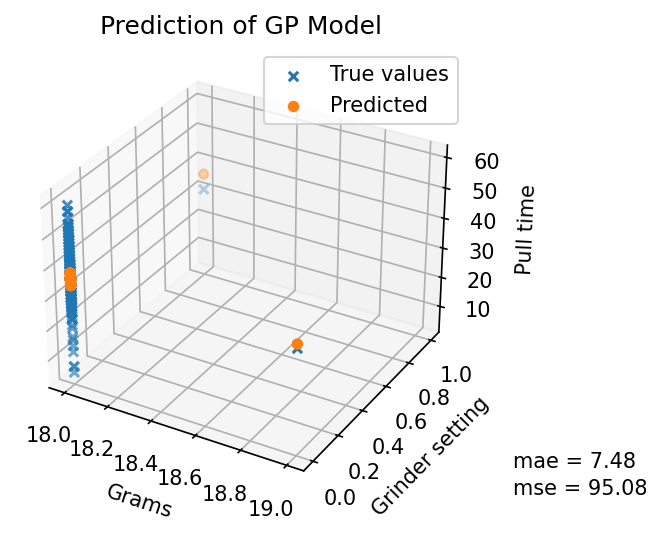

In [99]:
def prepare_df_for_gp(frame, prediction_column="time", encoded_cols=("grinder", "coffee", "roastdate", "grindersetting"), drop_cols=None):
    if drop_cols is None:
        drop_cols = []
    new_frame = frame.copy(deep=True)
    for col in drop_cols:
        new_frame = new_frame.drop([col], axis=1)
    for col in encoded_cols:
        if col not in new_frame:
            print("No such column:", col)
            continue
        encoder = OneHotEncoder(handle_unknown="ignore")
        new_frame[col] = encoder.fit_transform(np.asarray(new_frame[col]).reshape(-1, 1)).toarray()
    
    y = np.asarray(new_frame[prediction_column])
    new_frame = new_frame.drop([prediction_column, "arbitraryrating1-10", "tdsatagounfiltered", "brewratio", "date", "details", "machine", "output", "timeprediction"], axis=1)
    x = np.zeros((len(new_frame), len(new_frame.columns)), dtype=object)
    col_idxs = {}
    for i in range(len(new_frame)):
        for j, col in enumerate(sorted(new_frame.columns)):
            col_idxs[col] = j
            vals = np.asarray(new_frame[col].values[i])
            if isinstance(vals, np.ndarray) and col not in encoded_cols:
                x[i][j] = np.mean(vals)
            else:
                x[i][j] = vals
    return col_idxs, x, y

for dropped in [None]:
    print("With Dropped columns:", dropped)
    idxs, x, y = prepare_df_for_gp(train, drop_cols=dropped)
    gp = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), n_restarts_optimizer=9)
    gp.fit(x, y)
    idxs, x_val, y_val = prepare_df_for_gp(test, drop_cols=dropped)
    yfit, std_err = gp.predict(x_val, return_std=True)
    print(std_err)
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title("Prediction of GP Model")
    ax.set_xlabel("Grams")
    ax.set_ylabel("Grinder setting")
    ax.set_zlabel("Pull time")
    ax.scatter(
        x_val[:, idxs["coffeegrams"]],
        x_val[:, idxs["grindersetting"]],
        y_val,
        marker="x",
        label="True values",
    )
    ax.scatter(
        x_val[:, idxs["coffeegrams"]],
        x_val[:, idxs["grindersetting"]],
        yfit,
        marker="o",
        label="Predicted",
    )
    ax.legend()
    ax.annotate(
        "mse = {:.2f}".format(mean_squared_error(y_val, yfit)),
        (1.1, 0.01),
        xycoords="axes fraction",
    )
    ax.annotate(
        "mae = {:.2f}".format(mean_absolute_error(y_val, yfit)),
        (1.1, 0.07),
        xycoords="axes fraction",
    )
    plt.show()